# Red Convolucional con Pytorch Lightning


[Pytorch Lightning](https://lightning.ai/pytorch-lightning/) es una librería para entrenar y hacer deployment de modelos escritos en PyTorch. Implemente muchos de los aspectos ingenieriles (y a veces engorrosos) de entrenar redes profundas.

Instale Lightning en su ambiente con:

    pip install 'lightning[extra]' tensorboard

Lightning se basa en dos componentes:

- [`LightningModule`](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html): Reemplaza a  `torch.nn.Module` para escribir el modelo. Reorganiza y ordena ciertos aspectos del trabajo con el modelo.
- [`Trainer`](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-flags): Se hace cargo de automatizar el entrenamiento abstrayendo los detalles mecánicos de pytorch. Además tiene soporte para hacer `logging`, `checkpointing`, y selección de dispositivos coprocesadores. 
    
A continuación re-escribiremos el ejemplo de la red convolucional Lenet5 con Pytorch Lightning

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

mnist_train_data = MNIST(root='~/datasets/', train=True, download=True, transform=transforms.ToTensor())
mnist_train, mnist_valid = random_split(mnist_train_data, [50_000, 10_000], 
                                        generator=torch.Generator().manual_seed(1234))
train_loader = DataLoader(mnist_train, shuffle=True, 
                          batch_size=64, num_workers=4)
valid_loader = DataLoader(mnist_valid, shuffle=False, 
                          batch_size=512, num_workers=4)
mnist_test_data = MNIST(root='~/datasets/', train=False, download=True, 
                        transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test_data, shuffle=False, batch_size=512)

## Modificaciones en el modelo

- Se cambia la herencia de `torch.nn.Module` por `L.LightningModule`.
- Se debe agregar una función llamada `configure_optimizers` que declara el optimizador.
- Se debe agregar una función `training_step` con la lógica de entrenamiento para un batch. Destacar que la aplicación de `zero_grad`, `backward` y `step` la hace `Trainer`.

In [2]:
import torch
import torch.nn as nn
import lightning as L

class Lenet5(L.LightningModule):
    
    def __init__(self, learning_rate=1e-3):
        super(type(self), self).__init__()
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.features = nn.Sequential(nn.Conv2d(1, 6, 5, padding=2),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(6, 16, 5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(2))
        
        self.classifier = nn.Sequential(nn.Linear(16*5*5, 120),
                                        nn.ReLU(),
                                        nn.Linear(120, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 10))
        

    def forward(self, x):
        z = self.features(x)
        z = z.view(-1, 16*5*5)
        return self.classifier(z)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 
                                lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        data, labels = batch
        preds = self.forward(data)
        loss = criterion(preds, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        data, labels = batch
        preds = self.forward(data)
        loss = criterion(preds, labels)
        self.log("val_loss", loss)        
    
model = Lenet5()
print(model)

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Modificaciones en el entrenamiento

`Trainer` recibe el número máximo de épocas y el tipo de acelerador (CPU, GPU o TPU). Además recibe callbacks y loggers. Un *callback* ejecuta una función según una variable monitearada. En este caso se utilizan dos callbacks:

- [`ModelCheckpoint`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html): Guarda los pesos del modelo de mínima *loss* validación. 
- [`EarlyStopping`](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html): Detiene el entrenamiento si el la *loss* de validación no aumenta por 5 épocas

Los loggers en cambio se encargan de guardar información del entrenamiento. En este caso se utilizan dos:

- `CSVLogger`: Guarda las métricas en una tabla CSV
- `TensorBoardLogger`: Guarda las métricas en formato compatible con TensorBoard

El método `fit` realiza el entrenamiento. Recibe el modelo y los dataloaders de entrenamiento y validación.

In [3]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger

criterion = nn.CrossEntropyLoss(reduction='sum')
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode='min', save_top_k=1, filename='best_model')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=5)
trainer = L.Trainer(accelerator="auto", max_epochs=15, 
                    check_val_every_n_epoch=1, 
                    logger=[CSVLogger("logs"), TensorBoardLogger("logs")],
                    callbacks=[checkpoint_callback, early_stopping])

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 2.6 K 
1 | classifier | Sequential | 59.1 K
------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Podemos extraer la información del archivo CSV de métricas utilizando `pandas`

,train_loss,val_loss
epoch,,
0,268.090005,62.831699
1,78.748063,40.541679
2,34.772683,36.586685
3,51.330568,29.548756
4,45.717659,32.615692
5,40.952420,29.515028
6,40.411818,24.407499
7,34.545382,24.386267
8,48.819459,23.812349


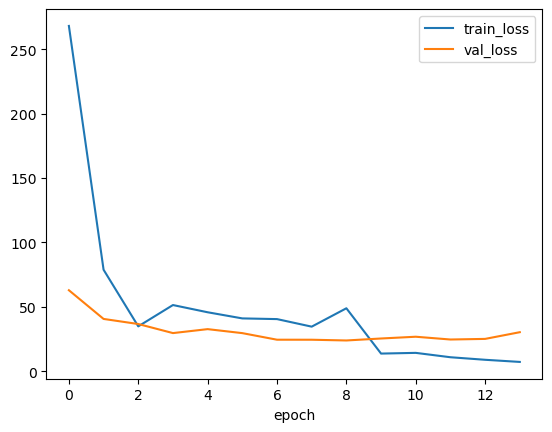

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics = metrics.groupby("epoch").sum()
display(metrics)

fig, ax = plt.subplots()
metrics[["train_loss", "val_loss"]].plot(ax=ax);

:::{note}
   
La mejor loss de validación ocurrió en la época 8. El entrenamiento se detuvo en la época 13 porque utilizamos EarlyStopping con paciencia de 5 épocas.

:::

Para visualizar con la interfaz de [TensorBoard](https://github.com/lanpa/tensorboardX):

    %load_ext tensorboard
    %tensorboard --logdir logs/lightning_logs

## Modificaciones en la evaluación

Primero recuperamos la red con menor costo de validación

In [6]:
model = Lenet5.load_from_checkpoint(f'{trainer.logger.log_dir}/checkpoints/best_model.ckpt')
model.eval()

Lenet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Lo demás procede de forma equivalente.

In [7]:
import numpy as np

test_targets = mnist_test_data.targets.numpy()
prediction_test = []

for mbdata, label in test_loader:
    logits = model(mbdata).detach()
    prediction_test.append(logits.argmax(dim=1).numpy())
prediction_test = np.concatenate(prediction_test)

Con esto podemos construir una matriz de confusión y un reporte usando las herramientas de `sklearn`

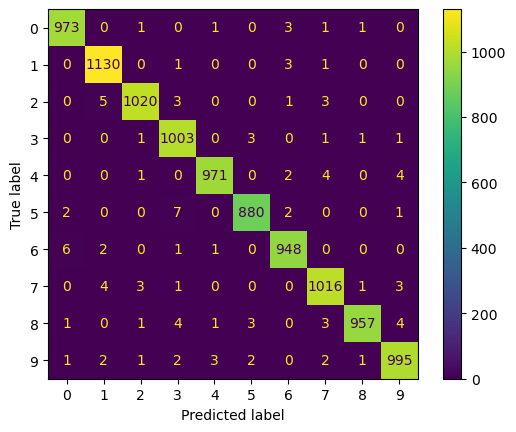

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(test_targets, prediction_test);

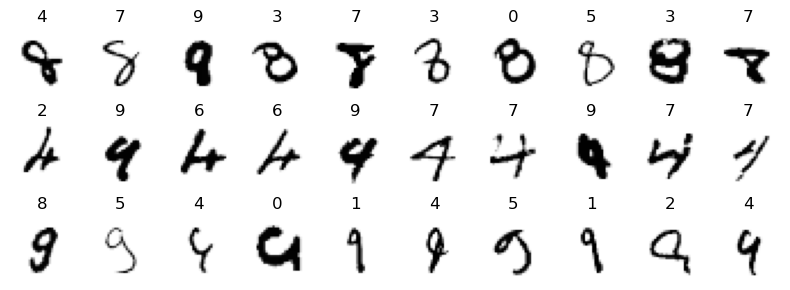

In [10]:
fig, ax = plt.subplots(3, 10, figsize=(8, 3), tight_layout=True)

for k, digit in enumerate([8, 4, 9]):    
    idx = np.where((test_targets == digit) & ~(prediction_test == digit))[0]
    for i in range(10):
        ax[k, i].axis('off')
        if i < len(idx):
            ax[k, i].set_title(prediction_test[idx[i]])
            ax[k, i].imshow(mnist_test_data[idx[i]][0].numpy()[0, :, :], cmap=plt.cm.Greys)
    

:::{seealso}

Puedes aprender más sobre Pytorch Lightning en: https://lightning.ai/docs/pytorch/stable/

:::